In [1]:
import numpy as np
from glob import glob
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from graph_kernels import shortest_path_kernel
import sys
from platform import processor


if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

if "x86" in processor():
    from sklearnex import patch_sklearn
    patch_sklearn()
    from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.metrics.pairwise import pairwise_distances

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, I load all adjacency matrices and their labels for the PPI and SHOCK data:

In [2]:
ppi_file_list = glob("./PPI/*.csv")
ppi_data = [
    np.loadtxt(file_path, delimiter=",", dtype=np.int64) for file_path in ppi_file_list
]
shock_file_list = glob("./SHOCK/*.csv")
shock_data = [
    np.loadtxt(file_path, delimiter=",", dtype=np.int64)
    for file_path in shock_file_list
]
ppi_labels = ppi_data[-1]
ppi_adj_matrices = np.delete(ppi_data, -1)
shock_labels = shock_data[-1]
shock_adj_matrices = np.delete(shock_data, -1)

del ppi_data, shock_data, ppi_file_list, shock_file_list

I now run the Shortest Path Kernel on the given adjacency matrices, and then evaluate the similarities to calculate pairwise distances.

In [3]:
sp_kernel = shortest_path_kernel()
sp_graphs = [
    sp_kernel.compute_shortest_paths_multi_process(ppi_adj_matrices),
    sp_kernel.compute_shortest_paths_multi_process(shock_adj_matrices),
]
ks = [
    sp_kernel.compute_similarities_multi_process(sp_graphs[0]),
    sp_kernel.compute_similarities_multi_process(sp_graphs[1]),
]
distance_matrices = [
    pairwise_distances(ks[0], metric="euclidean", n_jobs=-1),
    pairwise_distances(ks[1], metric="euclidean", n_jobs=-1),
]


Follow the computed pairwise distances displayed on a 2D raster, for both datasets:

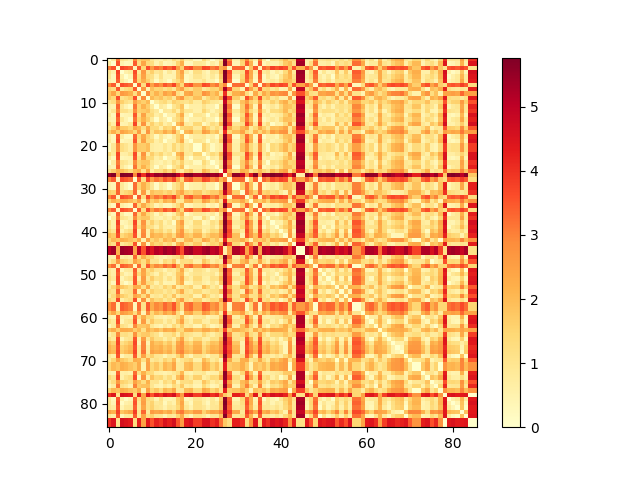

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.imshow(distance_matrices[0], zorder=2, cmap='YlOrRd', interpolation='nearest')
plt.colorbar();
plt.show()

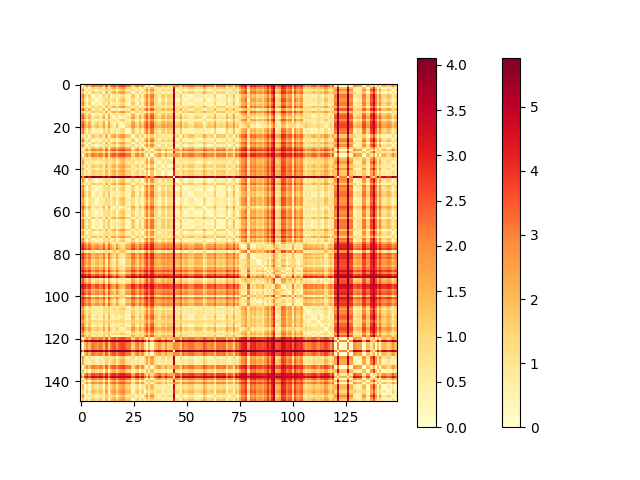

In [5]:
plt.imshow(distance_matrices[1], zorder=2, cmap='YlOrRd', interpolation='nearest')
plt.colorbar();
plt.show()

# SVM Linear Classifier and Manifold Learning methods
I now fit an SVM model with data transformed through my Shortest Path Kernel without any Manifold learning techniques. For simplicity and speed, I choose C = 1 as parameters, because to test the behaviour of different Cs together with the chosen Manifold techniques, the execution time would increase exponentially for each possible configuration, since I already test different configurations of Components and Neighbours with the chosen Manifolds.

In [6]:
from sklearn.model_selection import StratifiedKFold

stratified_k_fold = StratifiedKFold(n_splits=10, shuffle=True)  # 10
clf = SVC(kernel="linear", C=1.0)
ppi_labels = ppi_labels.ravel()
shock_labels = shock_labels.ravel()
ppi_scores = cross_val_score(
    estimator=clf,
    X=distance_matrices[0],
    y=ppi_labels,
    cv=stratified_k_fold,
    n_jobs=-1,
    verbose=0,
)
shock_scores = cross_val_score(
    estimator=clf,
    X=distance_matrices[1],
    y=shock_labels,
    cv=stratified_k_fold,
    n_jobs=-1,
    verbose=0,
)
print(
    " ".join(
        [
            "PPI Avarage accuracy without Manifold Learning: ",
            str(np.mean(ppi_scores)),
            "\n" "SHOCK Avarage accuracy without Manifold Learning: ",
            str(np.mean(shock_scores)),
        ]
    )
)


PPI Avarage accuracy without Manifold Learning:  0.7694444444444445 
SHOCK Avarage accuracy without Manifold Learning:  0.4000000000000001


As we can see the avarage accuracy on the PPI dataset is pretty good, wherease it's pretty low on the Shock one.

In [7]:
del sp_kernel, sp_graphs

I will now apply the techniques of Linear Local Embedding and Spectral Embedding manifold on each dataset with every possible combination of Neighbours and Componentns from 2 to 80 (and no more just because of the already high execution times).

In [8]:
import multiprocessing
import itertools
from graph_kernels import cross_validation_analysis

ppi_lle_results = []
shock_lle_results = []
ppi_spectral_results = []
shock_spectral_results = []

number_of_neighs_comps = 80
neigh_comps_combo = list(itertools.combinations(range(2, number_of_neighs_comps), 2))

with multiprocessing.Pool() as pool:
    ppi_lle_results = pool.map(
        cross_validation_analysis(
            manifold_technique=LocallyLinearEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[0],
            labels=ppi_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
        chunksize=5,
    )
    shock_lle_results = pool.map(
        cross_validation_analysis(
            manifold_technique=LocallyLinearEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[1],
            labels=shock_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
        chunksize=5,
    )
    ppi_spectral_results = pool.map(
        cross_validation_analysis(
            manifold_technique=SpectralEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[0],
            labels=ppi_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
        chunksize=5,
    )
    shock_spectral_results = pool.map(
        cross_validation_analysis(
            manifold_technique=SpectralEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[1],
            labels=shock_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
        chunksize=5,
    )

In [9]:
del neigh_comps_combo, 

In [10]:
ppi_lle_results = np.array(ppi_lle_results)
shock_lle_results = np.array(shock_lle_results)
ppi_spectral_results = np.array(ppi_spectral_results)
shock_spectral_results = np.array(shock_spectral_results)

I will now plot the average accuracies obtained with each combination of neighbours and components with each manifold technique on the two data sets and compare them with the accuracies obtained without manifold techniques.

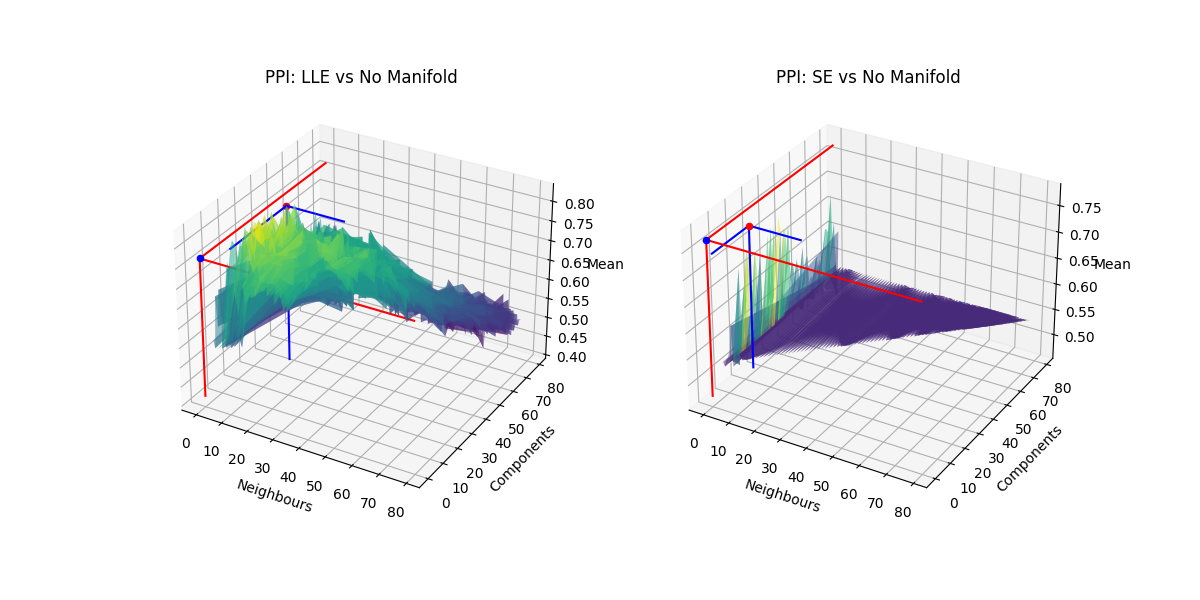

In [11]:
import imageio
from matplotlib import animation


def compare_scores(linear_result, number_of_neighs_comps, reshape_rows, reshape_col, titles, *manifold_results):
    if len(manifold_results) != 2:
        raise Exception("You can compare just two ")
    linear_result = np.mean(linear_result)
    fig = plt.figure(figsize=(12, 6), dpi=100)
    subaxes = [
        fig.add_subplot(121, projection="3d"),
        fig.add_subplot(122, projection="3d"),
    ]
    for i in range(0, 2):
        accuracies = manifold_results[i][:, 0].astype(float)
        neighbours = manifold_results[i][:, 1].astype(int)
        components = manifold_results[i][:, 2].astype(int)
        subaxes[i].plot_surface(
            np.reshape(neighbours, (reshape_rows, reshape_col)),
            np.reshape(components, (reshape_rows, reshape_col)),
            np.reshape(accuracies, (reshape_rows, reshape_col)),
            alpha=0.5,
            rstride=1,
            cstride=1,
            cmap="viridis",
            edgecolor="none",
        )
        subaxes[i].set_xlabel("Neighbours")
        subaxes[i].set_ylabel("Components")
        subaxes[i].set_zlabel("Mean")

        max_mean = manifold_results[i][:, 0].astype(float).max()
        min_mean = manifold_results[i][:, 0].astype(float).min()
        index_of_max = np.where(accuracies == max_mean)[0][0]

        subaxes[i].plot(
            [neighbours[index_of_max], neighbours[index_of_max]],
            [components[index_of_max], components[index_of_max]],
            [min_mean, max_mean],
            zorder=3,
            color="blue",
        )  # AVG ACCURACIES
        subaxes[i].plot(
            [components[index_of_max], neighbours[index_of_max]],
            [components[index_of_max], components[index_of_max]],
            [max_mean, max_mean],
            zorder=3,
            color="blue",
        )  # NEIGHBOURS
        subaxes[i].plot(
            [neighbours[index_of_max], neighbours[index_of_max]],
            [0, components[index_of_max]],
            [max_mean, max_mean],
            zorder=3,
            color="blue",
        )  # COMPONENTS
        subaxes[i].scatter(
            neighbours[index_of_max], components[index_of_max], max_mean, color="red"
        )  # SCORE WITH MANIFOLD
        subaxes[i].scatter(0, 0, linear_result, color="blue")  # SCORE WITHOUT MANIFOLD

        subaxes[i].plot(
            [0, 0], [0, 0], [min_mean, linear_result], zorder=3, color="red"
        )  # AVG ACCURACIES
        subaxes[i].plot(
            [0, number_of_neighs_comps - 1],
            [0, 0],
            [linear_result, linear_result],
            zorder=3,
            color="red",
        )  # NEIGHBOURS
        subaxes[i].plot(
            [0, 0],
            [0, number_of_neighs_comps - 1],
            [linear_result, linear_result],
            zorder=3,
            color="red",
        )  # COMPONENTS
        subaxes[i].title.set_text(titles[i])
    
    return fig


ticks = 0

def animate(n):
    global figure
    global ticks
    axes = figure.axes
    axes[0].azim += 1.1
    axes[1].azim += 1.1
    ticks += 1.1
    return figure,

def reset_plot_pov():
    global figure
    global ticks
    axes = figure.axes
    axes[0].azim -= ticks
    axes[1].azim -= ticks
    ticks = 0

def save_3d_plots(path, figure):
    anim = animation.FuncAnimation(fig = figure, func = animate, frames = 150, interval = 1, repeat = False)
    writergif = animation.PillowWriter(fps=60) 
    anim.save(path + '.gif', writer=writergif)

figure = compare_scores(ppi_scores, number_of_neighs_comps, 21, 143, ['PPI: LLE vs No Manifold', 'PPI: SE vs No Manifold'], ppi_lle_results, ppi_spectral_results)
save_3d_plots('ppi_comparison', figure)
reset_plot_pov()


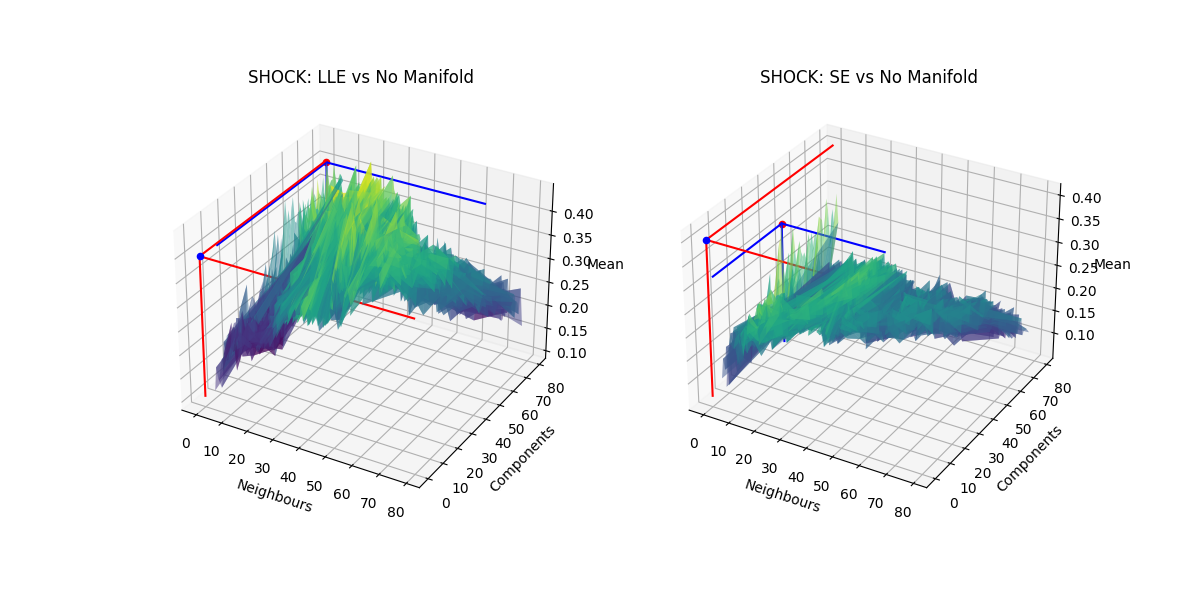

In [12]:
figure = compare_scores(shock_scores, number_of_neighs_comps, 21, 143, ['SHOCK: LLE vs No Manifold', 'SHOCK: SE vs No Manifold'], shock_lle_results, shock_spectral_results)
save_3d_plots('shock_comparison', figure)
reset_plot_pov()

As can be seen from the comparison graphs, the LLE technique brings a slight improvement in the accuracies on both datasets, while Spectral Embedding degenerates the peroformances a lot. This situation almost always occurs even with data shuffling, with the exception of a few very rare situations in which SHOCK with SE produces better accuracies than without manifold.

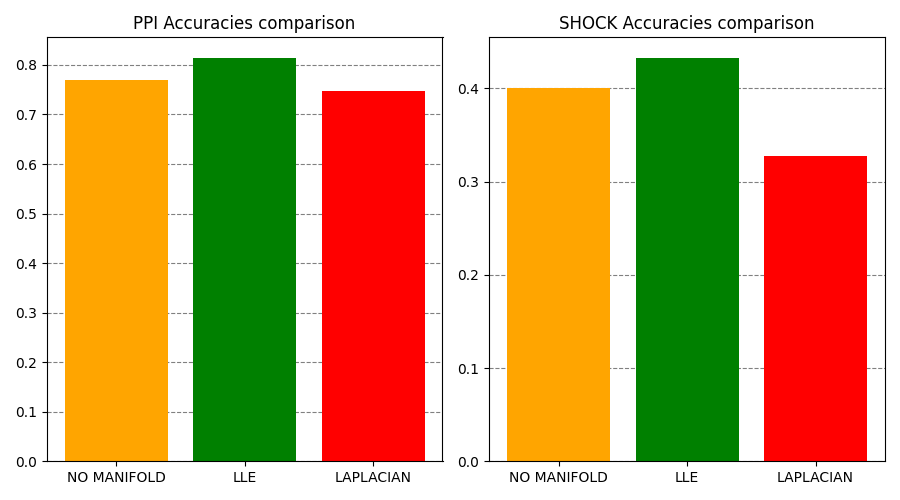

In [13]:
left = [1, 2, 3]
ppi_accuracies = np.array([
    np.mean(ppi_scores),
    ppi_lle_results[:, 0].astype(float).max(),
    ppi_spectral_results[:, 0].astype(float).max(),]
)

shock_accuracies = np.array([
    np.mean(shock_scores),
    shock_lle_results[:, 0].astype(float).max(),
    shock_spectral_results[:, 0].astype(float).max(),]
)


def match_colours(values):
    max_val = values.max()
    min_val = values.min()
    return ['green' if value == max_val else 'red' if value == min_val else 'orange' for value in values]



tick_label = ["NO MANIFOLD", "LLE", "LAPLACIAN"]

fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(9, 5)

axs[0].bar(
    left,
    ppi_accuracies,
    tick_label=tick_label,
    width=0.8,
    color= match_colours(ppi_accuracies)#["orange", "green", "red"],
)
axs[0].set_title("PPI Accuracies comparison")
axs[0].set_axisbelow(True)
axs[0].yaxis.grid(color='gray', linestyle='dashed')

axs[1].bar(
    left,
    shock_accuracies,
    tick_label=tick_label,
    width=0.8,
    color= match_colours(shock_accuracies)#["orange", "green", "red"],
)
axs[1].set_title("SHOCK Accuracies comparison")
axs[1].set_axisbelow(True)
axs[1].yaxis.grid(color='gray', linestyle='dashed')



We can also see which are the combinations of neighbours and components which led to the best accuracies for both the Manifold techniques over the two datasets:

In [14]:
ppi_lle_max_accuracy_index  =  np.where(ppi_lle_results[:, 0].astype(float) == ppi_accuracies[1])
ppi_lle_max_accuracy_neigh =  ppi_lle_results[ppi_lle_max_accuracy_index, 1].astype(int)
ppi_lle_max_accuracy_comp =  ppi_lle_results[ppi_lle_max_accuracy_index, 2].astype(int)

ppi_spectral_max_accuracy_index  =  np.where(ppi_spectral_results[:, 0].astype(float) == ppi_accuracies[2])
ppi_spectral_max_accuracy_neigh =  ppi_spectral_results[ppi_spectral_max_accuracy_index, 1].astype(int)
ppi_spectral_max_accuracy_comp =  ppi_spectral_results[ppi_spectral_max_accuracy_index, 2].astype(int)

shock_lle_max_accuracy_index  =  np.where(shock_lle_results[:, 0].astype(float) == shock_accuracies[1])
shock_lle_max_accuracy_neigh =  shock_lle_results[shock_lle_max_accuracy_index, 1].astype(int)
shock_lle_max_accuracy_comp =  shock_lle_results[shock_lle_max_accuracy_index, 2].astype(int)

shock_spectral_max_accuracy_index  =  np.where(shock_spectral_results[:, 0].astype(float) == shock_accuracies[2])
shock_spectral_max_accuracy_neigh =  shock_spectral_results[shock_spectral_max_accuracy_index, 1].astype(int)
shock_spectral_max_accuracy_comp =  shock_spectral_results[shock_spectral_max_accuracy_index, 2].astype(int)



print("".join(["BEST PPI-LLE ACCURACY: NEIGHBOURS: ", str(ppi_lle_max_accuracy_neigh[0][0]) , " AND COMPONENTS: ", str(ppi_lle_max_accuracy_comp[0][0])]))
print("".join(["BEST PPI-SE ACCURACY: NEIGHBOURS: ", str(ppi_spectral_max_accuracy_neigh[0][0]) , " AND COMPONENTS: ", str(ppi_spectral_max_accuracy_comp[0][0])]))
print("".join(["BEST SHOCK-LLE ACCURACY: NEIGHBOURS: ", str(shock_lle_max_accuracy_neigh[0][0]) , " AND COMPONENTS: ", str(shock_lle_max_accuracy_comp[0][0])]))
print("".join(["BEST SHOCK-SE ACCURACY: NEIGHBOURS: ", str(shock_spectral_max_accuracy_neigh[0][0]) , " AND COMPONENTS: ", str(shock_spectral_max_accuracy_comp[0][0])]))


BEST PPI-LLE ACCURACY: NEIGHBOURS: 12 AND COMPONENTS: 34
BEST PPI-SE ACCURACY: NEIGHBOURS: 2 AND COMPONENTS: 22
BEST SHOCK-LLE ACCURACY: NEIGHBOURS: 7 AND COMPONENTS: 68
BEST SHOCK-SE ACCURACY: NEIGHBOURS: 2 AND COMPONENTS: 42
